Original at: https://github.com/sthorn/deep-learning-explorations/blob/master/predicting-uncertainty.ipynb

# Predicting uncertainty with (deep) neural networks

The idea is that a network that outputs a real-valued prediction can be (simply) modified to provide an estimate of the error on this prediction. Roughly speaking we do:

* Add an additional real-valued output to the network. The network now predicts two values: the output, $y$, and its error, $\sigma$

* Estimate the target value for the error, $\sigma$, from the difference between the target value of the output, $y$, and its predicted value, $\hat{y}$. We can use either: $\sigma^2 = (y-\hat{y})^2$ or $\sigma = \left| y-\hat{y}\right|$

* An easy way to do this at training time is with a customised loss function

### Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as m
import torch
from torch.autograd import Variable
import torch.nn.functional as F

%matplotlib inline

### Generate some random data

In [2]:
# Generate some linearly related data
n_samples = 10000
np.random.seed(4567)
x = np.random.random(n_samples)
eps = np.random.normal(scale=1.0, size=n_samples) * 0.4*np.sin(x*4*np.pi)
y = 2*x + 1 + eps

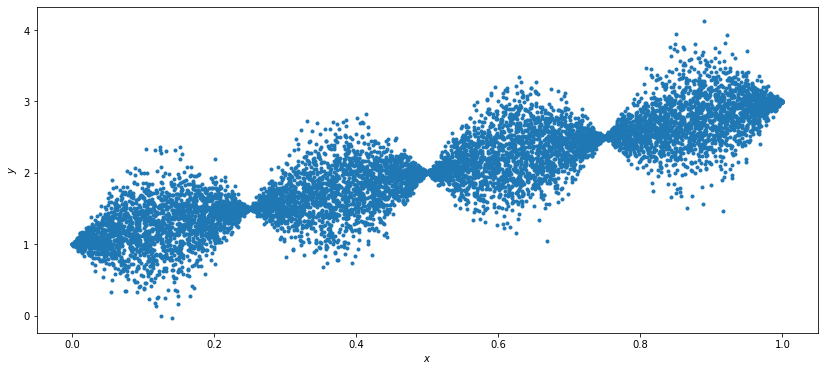

In [3]:
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [4]:
# Add in column of dummy zeros to represent sigma 
sigma = np.zeros(10000)
y = np.stack([y, sigma], axis=1)

In [5]:
# Reshape x for PyTorch
x = x.reshape(10000, 1)

In [6]:
# Split into training and validation sets
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

In [7]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.FloatTensor
x = Variable(torch.from_numpy(x).type(dtype))
y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [8]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x.shape, y.shape

(torch.Size([9500, 1]), torch.Size([9500, 2]))

### Create a simple network 

In [9]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           )

In [10]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Custom loss function
This is where the magic happens.

In [11]:
def custom_loss(input, target):
    
    # Estimate target value for sigma with abs(y_pred - y)
    #
    #    actual y     is target[:,0]
    # predicted y     is input[:,0]
    #    actual sigma is target[:,1]
    # predicted sigma is input[:,1]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data).abs(), 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [12]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x)
    
    # Calculate loss
    loss = custom_loss(y_pred, y)
    
    if i%500 == 0: print(f'epoch: {i:4}, loss: {loss.data:.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

0
tensor(5.1015)
epoch:    0, loss: 5.1
1
tensor(4.9142)
2
tensor(4.7312)
3
tensor(4.5523)
4
tensor(4.3776)
5
tensor(4.2072)
6
tensor(4.0412)
7
tensor(3.8794)
8
tensor(3.7221)
9
tensor(3.5692)
10
tensor(3.4207)
11
tensor(3.2767)
12
tensor(3.1371)
13
tensor(3.0019)
14
tensor(2.8712)
15
tensor(2.7449)
16
tensor(2.6231)
17
tensor(2.5056)
18
tensor(2.3925)
19
tensor(2.2836)
20
tensor(2.1791)
21
tensor(2.0787)
22
tensor(1.9826)
23
tensor(1.8905)
24
tensor(1.8024)
25
tensor(1.7183)
26
tensor(1.6381)
27
tensor(1.5616)
28
tensor(1.4888)
29
tensor(1.4196)
30
tensor(1.3539)
31
tensor(1.2916)
32
tensor(1.2326)
33
tensor(1.1767)
34
tensor(1.1239)
35
tensor(1.0740)
36
tensor(1.0268)
37
tensor(0.9823)
38
tensor(0.9404)
39
tensor(0.9009)
40
tensor(0.8637)
41
tensor(0.8286)
42
tensor(0.7954)
43
tensor(0.7641)
44
tensor(0.7345)
45
tensor(0.7066)
46
tensor(0.6803)
47
tensor(0.6556)
48
tensor(0.6324)
49
tensor(0.6104)
50
tensor(0.5898)
51
tensor(0.5704)
52
tensor(0.5520)
53
tensor(0.5347)
54
tensor(0.518

436
tensor(0.0625)
437
tensor(0.0625)
438
tensor(0.0625)
439
tensor(0.0625)
440
tensor(0.0625)
441
tensor(0.0625)
442
tensor(0.0625)
443
tensor(0.0624)
444
tensor(0.0624)
445
tensor(0.0624)
446
tensor(0.0624)
447
tensor(0.0624)
448
tensor(0.0624)
449
tensor(0.0624)
450
tensor(0.0624)
451
tensor(0.0624)
452
tensor(0.0624)
453
tensor(0.0624)
454
tensor(0.0623)
455
tensor(0.0623)
456
tensor(0.0623)
457
tensor(0.0623)
458
tensor(0.0623)
459
tensor(0.0623)
460
tensor(0.0623)
461
tensor(0.0623)
462
tensor(0.0623)
463
tensor(0.0623)
464
tensor(0.0623)
465
tensor(0.0623)
466
tensor(0.0623)
467
tensor(0.0623)
468
tensor(0.0622)
469
tensor(0.0622)
470
tensor(0.0622)
471
tensor(0.0622)
472
tensor(0.0622)
473
tensor(0.0622)
474
tensor(0.0622)
475
tensor(0.0622)
476
tensor(0.0622)
477
tensor(0.0622)
478
tensor(0.0622)
479
tensor(0.0622)
480
tensor(0.0622)
481
tensor(0.0622)
482
tensor(0.0622)
483
tensor(0.0622)
484
tensor(0.0622)
485
tensor(0.0621)
486
tensor(0.0621)
487
tensor(0.0621)
488
tensor(0

866
tensor(0.0615)
867
tensor(0.0615)
868
tensor(0.0615)
869
tensor(0.0615)
870
tensor(0.0615)
871
tensor(0.0615)
872
tensor(0.0615)
873
tensor(0.0615)
874
tensor(0.0615)
875
tensor(0.0615)
876
tensor(0.0615)
877
tensor(0.0615)
878
tensor(0.0615)
879
tensor(0.0615)
880
tensor(0.0615)
881
tensor(0.0615)
882
tensor(0.0615)
883
tensor(0.0615)
884
tensor(0.0615)
885
tensor(0.0615)
886
tensor(0.0615)
887
tensor(0.0615)
888
tensor(0.0615)
889
tensor(0.0615)
890
tensor(0.0615)
891
tensor(0.0615)
892
tensor(0.0615)
893
tensor(0.0615)
894
tensor(0.0615)
895
tensor(0.0615)
896
tensor(0.0615)
897
tensor(0.0615)
898
tensor(0.0615)
899
tensor(0.0615)
900
tensor(0.0615)
901
tensor(0.0615)
902
tensor(0.0615)
903
tensor(0.0615)
904
tensor(0.0615)
905
tensor(0.0615)
906
tensor(0.0615)
907
tensor(0.0615)
908
tensor(0.0615)
909
tensor(0.0615)
910
tensor(0.0615)
911
tensor(0.0615)
912
tensor(0.0615)
913
tensor(0.0615)
914
tensor(0.0615)
915
tensor(0.0615)
916
tensor(0.0615)
917
tensor(0.0615)
918
tensor(0

1283
tensor(0.0613)
1284
tensor(0.0613)
1285
tensor(0.0613)
1286
tensor(0.0613)
1287
tensor(0.0613)
1288
tensor(0.0613)
1289
tensor(0.0613)
1290
tensor(0.0613)
1291
tensor(0.0613)
1292
tensor(0.0613)
1293
tensor(0.0613)
1294
tensor(0.0613)
1295
tensor(0.0613)
1296
tensor(0.0613)
1297
tensor(0.0613)
1298
tensor(0.0613)
1299
tensor(0.0613)
1300
tensor(0.0613)
1301
tensor(0.0613)
1302
tensor(0.0613)
1303
tensor(0.0613)
1304
tensor(0.0613)
1305
tensor(0.0613)
1306
tensor(0.0613)
1307
tensor(0.0613)
1308
tensor(0.0613)
1309
tensor(0.0613)
1310
tensor(0.0613)
1311
tensor(0.0613)
1312
tensor(0.0612)
1313
tensor(0.0612)
1314
tensor(0.0612)
1315
tensor(0.0612)
1316
tensor(0.0612)
1317
tensor(0.0612)
1318
tensor(0.0612)
1319
tensor(0.0612)
1320
tensor(0.0612)
1321
tensor(0.0612)
1322
tensor(0.0612)
1323
tensor(0.0612)
1324
tensor(0.0612)
1325
tensor(0.0612)
1326
tensor(0.0612)
1327
tensor(0.0612)
1328
tensor(0.0612)
1329
tensor(0.0612)
1330
tensor(0.0612)
1331
tensor(0.0612)
1332
tensor(0.0612)


1692
tensor(0.0611)
1693
tensor(0.0610)
1694
tensor(0.0610)
1695
tensor(0.0610)
1696
tensor(0.0610)
1697
tensor(0.0610)
1698
tensor(0.0610)
1699
tensor(0.0610)
1700
tensor(0.0610)
1701
tensor(0.0610)
1702
tensor(0.0610)
1703
tensor(0.0610)
1704
tensor(0.0610)
1705
tensor(0.0610)
1706
tensor(0.0610)
1707
tensor(0.0610)
1708
tensor(0.0610)
1709
tensor(0.0610)
1710
tensor(0.0610)
1711
tensor(0.0610)
1712
tensor(0.0610)
1713
tensor(0.0610)
1714
tensor(0.0610)
1715
tensor(0.0610)
1716
tensor(0.0610)
1717
tensor(0.0610)
1718
tensor(0.0610)
1719
tensor(0.0610)
1720
tensor(0.0610)
1721
tensor(0.0610)
1722
tensor(0.0610)
1723
tensor(0.0610)
1724
tensor(0.0610)
1725
tensor(0.0610)
1726
tensor(0.0610)
1727
tensor(0.0610)
1728
tensor(0.0610)
1729
tensor(0.0610)
1730
tensor(0.0610)
1731
tensor(0.0610)
1732
tensor(0.0610)
1733
tensor(0.0610)
1734
tensor(0.0610)
1735
tensor(0.0610)
1736
tensor(0.0610)
1737
tensor(0.0610)
1738
tensor(0.0610)
1739
tensor(0.0610)
1740
tensor(0.0610)
1741
tensor(0.0610)


2102
tensor(0.0608)
2103
tensor(0.0608)
2104
tensor(0.0608)
2105
tensor(0.0608)
2106
tensor(0.0608)
2107
tensor(0.0608)
2108
tensor(0.0608)
2109
tensor(0.0608)
2110
tensor(0.0608)
2111
tensor(0.0608)
2112
tensor(0.0608)
2113
tensor(0.0608)
2114
tensor(0.0608)
2115
tensor(0.0608)
2116
tensor(0.0608)
2117
tensor(0.0608)
2118
tensor(0.0608)
2119
tensor(0.0608)
2120
tensor(0.0608)
2121
tensor(0.0608)
2122
tensor(0.0608)
2123
tensor(0.0608)
2124
tensor(0.0608)
2125
tensor(0.0608)
2126
tensor(0.0608)
2127
tensor(0.0608)
2128
tensor(0.0608)
2129
tensor(0.0608)
2130
tensor(0.0608)
2131
tensor(0.0608)
2132
tensor(0.0608)
2133
tensor(0.0608)
2134
tensor(0.0608)
2135
tensor(0.0608)
2136
tensor(0.0608)
2137
tensor(0.0608)
2138
tensor(0.0608)
2139
tensor(0.0608)
2140
tensor(0.0608)
2141
tensor(0.0608)
2142
tensor(0.0608)
2143
tensor(0.0608)
2144
tensor(0.0608)
2145
tensor(0.0608)
2146
tensor(0.0608)
2147
tensor(0.0608)
2148
tensor(0.0608)
2149
tensor(0.0608)
2150
tensor(0.0608)
2151
tensor(0.0608)


2511
tensor(0.0606)
2512
tensor(0.0606)
2513
tensor(0.0606)
2514
tensor(0.0606)
2515
tensor(0.0606)
2516
tensor(0.0606)
2517
tensor(0.0606)
2518
tensor(0.0606)
2519
tensor(0.0606)
2520
tensor(0.0606)
2521
tensor(0.0606)
2522
tensor(0.0606)
2523
tensor(0.0606)
2524
tensor(0.0606)
2525
tensor(0.0606)
2526
tensor(0.0606)
2527
tensor(0.0606)
2528
tensor(0.0606)
2529
tensor(0.0606)
2530
tensor(0.0606)
2531
tensor(0.0606)
2532
tensor(0.0606)
2533
tensor(0.0606)
2534
tensor(0.0606)
2535
tensor(0.0606)
2536
tensor(0.0606)
2537
tensor(0.0606)
2538
tensor(0.0606)
2539
tensor(0.0606)
2540
tensor(0.0606)
2541
tensor(0.0606)
2542
tensor(0.0606)
2543
tensor(0.0606)
2544
tensor(0.0606)
2545
tensor(0.0606)
2546
tensor(0.0606)
2547
tensor(0.0606)
2548
tensor(0.0606)
2549
tensor(0.0606)
2550
tensor(0.0606)
2551
tensor(0.0606)
2552
tensor(0.0606)
2553
tensor(0.0606)
2554
tensor(0.0606)
2555
tensor(0.0606)
2556
tensor(0.0606)
2557
tensor(0.0606)
2558
tensor(0.0606)
2559
tensor(0.0606)
2560
tensor(0.0606)


2922
tensor(0.0605)
2923
tensor(0.0605)
2924
tensor(0.0605)
2925
tensor(0.0605)
2926
tensor(0.0605)
2927
tensor(0.0605)
2928
tensor(0.0604)
2929
tensor(0.0604)
2930
tensor(0.0604)
2931
tensor(0.0604)
2932
tensor(0.0604)
2933
tensor(0.0604)
2934
tensor(0.0604)
2935
tensor(0.0604)
2936
tensor(0.0604)
2937
tensor(0.0604)
2938
tensor(0.0604)
2939
tensor(0.0604)
2940
tensor(0.0604)
2941
tensor(0.0604)
2942
tensor(0.0604)
2943
tensor(0.0604)
2944
tensor(0.0604)
2945
tensor(0.0604)
2946
tensor(0.0604)
2947
tensor(0.0604)
2948
tensor(0.0604)
2949
tensor(0.0604)
2950
tensor(0.0604)
2951
tensor(0.0604)
2952
tensor(0.0604)
2953
tensor(0.0604)
2954
tensor(0.0604)
2955
tensor(0.0604)
2956
tensor(0.0604)
2957
tensor(0.0604)
2958
tensor(0.0604)
2959
tensor(0.0604)
2960
tensor(0.0604)
2961
tensor(0.0604)
2962
tensor(0.0604)
2963
tensor(0.0604)
2964
tensor(0.0604)
2965
tensor(0.0604)
2966
tensor(0.0604)
2967
tensor(0.0604)
2968
tensor(0.0604)
2969
tensor(0.0604)
2970
tensor(0.0604)
2971
tensor(0.0604)


3331
tensor(0.0603)
3332
tensor(0.0603)
3333
tensor(0.0603)
3334
tensor(0.0603)
3335
tensor(0.0603)
3336
tensor(0.0603)
3337
tensor(0.0603)
3338
tensor(0.0603)
3339
tensor(0.0603)
3340
tensor(0.0603)
3341
tensor(0.0602)
3342
tensor(0.0602)
3343
tensor(0.0602)
3344
tensor(0.0602)
3345
tensor(0.0602)
3346
tensor(0.0602)
3347
tensor(0.0602)
3348
tensor(0.0602)
3349
tensor(0.0602)
3350
tensor(0.0602)
3351
tensor(0.0602)
3352
tensor(0.0602)
3353
tensor(0.0602)
3354
tensor(0.0602)
3355
tensor(0.0602)
3356
tensor(0.0602)
3357
tensor(0.0602)
3358
tensor(0.0602)
3359
tensor(0.0602)
3360
tensor(0.0602)
3361
tensor(0.0602)
3362
tensor(0.0602)
3363
tensor(0.0602)
3364
tensor(0.0602)
3365
tensor(0.0602)
3366
tensor(0.0602)
3367
tensor(0.0602)
3368
tensor(0.0602)
3369
tensor(0.0602)
3370
tensor(0.0602)
3371
tensor(0.0602)
3372
tensor(0.0602)
3373
tensor(0.0602)
3374
tensor(0.0602)
3375
tensor(0.0602)
3376
tensor(0.0602)
3377
tensor(0.0602)
3378
tensor(0.0602)
3379
tensor(0.0602)
3380
tensor(0.0602)


3740
tensor(0.0600)
3741
tensor(0.0600)
3742
tensor(0.0600)
3743
tensor(0.0600)
3744
tensor(0.0600)
3745
tensor(0.0600)
3746
tensor(0.0600)
3747
tensor(0.0600)
3748
tensor(0.0600)
3749
tensor(0.0600)
3750
tensor(0.0600)
3751
tensor(0.0600)
3752
tensor(0.0600)
3753
tensor(0.0600)
3754
tensor(0.0600)
3755
tensor(0.0600)
3756
tensor(0.0600)
3757
tensor(0.0600)
3758
tensor(0.0600)
3759
tensor(0.0600)
3760
tensor(0.0600)
3761
tensor(0.0600)
3762
tensor(0.0600)
3763
tensor(0.0600)
3764
tensor(0.0600)
3765
tensor(0.0600)
3766
tensor(0.0600)
3767
tensor(0.0600)
3768
tensor(0.0600)
3769
tensor(0.0600)
3770
tensor(0.0600)
3771
tensor(0.0600)
3772
tensor(0.0600)
3773
tensor(0.0600)
3774
tensor(0.0600)
3775
tensor(0.0600)
3776
tensor(0.0600)
3777
tensor(0.0600)
3778
tensor(0.0600)
3779
tensor(0.0600)
3780
tensor(0.0600)
3781
tensor(0.0600)
3782
tensor(0.0600)
3783
tensor(0.0600)
3784
tensor(0.0600)
3785
tensor(0.0600)
3786
tensor(0.0600)
3787
tensor(0.0600)
3788
tensor(0.0600)
3789
tensor(0.0600)


4150
tensor(0.0598)
4151
tensor(0.0598)
4152
tensor(0.0598)
4153
tensor(0.0598)
4154
tensor(0.0598)
4155
tensor(0.0598)
4156
tensor(0.0598)
4157
tensor(0.0598)
4158
tensor(0.0598)
4159
tensor(0.0598)
4160
tensor(0.0598)
4161
tensor(0.0598)
4162
tensor(0.0598)
4163
tensor(0.0598)
4164
tensor(0.0598)
4165
tensor(0.0598)
4166
tensor(0.0598)
4167
tensor(0.0598)
4168
tensor(0.0598)
4169
tensor(0.0598)
4170
tensor(0.0598)
4171
tensor(0.0598)
4172
tensor(0.0598)
4173
tensor(0.0598)
4174
tensor(0.0598)
4175
tensor(0.0598)
4176
tensor(0.0598)
4177
tensor(0.0598)
4178
tensor(0.0598)
4179
tensor(0.0598)
4180
tensor(0.0598)
4181
tensor(0.0598)
4182
tensor(0.0598)
4183
tensor(0.0598)
4184
tensor(0.0598)
4185
tensor(0.0598)
4186
tensor(0.0598)
4187
tensor(0.0598)
4188
tensor(0.0598)
4189
tensor(0.0598)
4190
tensor(0.0598)
4191
tensor(0.0598)
4192
tensor(0.0598)
4193
tensor(0.0598)
4194
tensor(0.0598)
4195
tensor(0.0598)
4196
tensor(0.0598)
4197
tensor(0.0598)
4198
tensor(0.0598)
4199
tensor(0.0598)


4560
tensor(0.0596)
4561
tensor(0.0596)
4562
tensor(0.0596)
4563
tensor(0.0596)
4564
tensor(0.0596)
4565
tensor(0.0596)
4566
tensor(0.0596)
4567
tensor(0.0596)
4568
tensor(0.0596)
4569
tensor(0.0596)
4570
tensor(0.0596)
4571
tensor(0.0596)
4572
tensor(0.0596)
4573
tensor(0.0596)
4574
tensor(0.0596)
4575
tensor(0.0596)
4576
tensor(0.0596)
4577
tensor(0.0596)
4578
tensor(0.0596)
4579
tensor(0.0596)
4580
tensor(0.0596)
4581
tensor(0.0596)
4582
tensor(0.0596)
4583
tensor(0.0596)
4584
tensor(0.0596)
4585
tensor(0.0596)
4586
tensor(0.0596)
4587
tensor(0.0596)
4588
tensor(0.0596)
4589
tensor(0.0596)
4590
tensor(0.0596)
4591
tensor(0.0596)
4592
tensor(0.0596)
4593
tensor(0.0596)
4594
tensor(0.0596)
4595
tensor(0.0596)
4596
tensor(0.0596)
4597
tensor(0.0596)
4598
tensor(0.0596)
4599
tensor(0.0596)
4600
tensor(0.0596)
4601
tensor(0.0596)
4602
tensor(0.0596)
4603
tensor(0.0596)
4604
tensor(0.0596)
4605
tensor(0.0596)
4606
tensor(0.0596)
4607
tensor(0.0596)
4608
tensor(0.0596)
4609
tensor(0.0596)


4970
tensor(0.0594)
4971
tensor(0.0594)
4972
tensor(0.0594)
4973
tensor(0.0594)
4974
tensor(0.0594)
4975
tensor(0.0594)
4976
tensor(0.0594)
4977
tensor(0.0594)
4978
tensor(0.0594)
4979
tensor(0.0594)
4980
tensor(0.0594)
4981
tensor(0.0594)
4982
tensor(0.0594)
4983
tensor(0.0594)
4984
tensor(0.0594)
4985
tensor(0.0594)
4986
tensor(0.0594)
4987
tensor(0.0594)
4988
tensor(0.0594)
4989
tensor(0.0594)
4990
tensor(0.0594)
4991
tensor(0.0594)
4992
tensor(0.0594)
4993
tensor(0.0594)
4994
tensor(0.0594)
4995
tensor(0.0594)
4996
tensor(0.0594)
4997
tensor(0.0594)
4998
tensor(0.0594)
4999
tensor(0.0594)
5000
tensor(0.0594)
epoch: 5000, loss: 0.0594
5001
tensor(0.0594)
5002
tensor(0.0594)
5003
tensor(0.0594)
5004
tensor(0.0594)
5005
tensor(0.0594)
5006
tensor(0.0593)
5007
tensor(0.0593)
5008
tensor(0.0593)
5009
tensor(0.0593)
5010
tensor(0.0593)
5011
tensor(0.0593)
5012
tensor(0.0593)
5013
tensor(0.0593)
5014
tensor(0.0593)
5015
tensor(0.0593)
5016
tensor(0.0593)
5017
tensor(0.0593)
5018
tensor(0.

5379
tensor(0.0591)
5380
tensor(0.0591)
5381
tensor(0.0591)
5382
tensor(0.0591)
5383
tensor(0.0591)
5384
tensor(0.0591)
5385
tensor(0.0591)
5386
tensor(0.0591)
5387
tensor(0.0591)
5388
tensor(0.0591)
5389
tensor(0.0591)
5390
tensor(0.0591)
5391
tensor(0.0591)
5392
tensor(0.0591)
5393
tensor(0.0591)
5394
tensor(0.0591)
5395
tensor(0.0591)
5396
tensor(0.0591)
5397
tensor(0.0591)
5398
tensor(0.0591)
5399
tensor(0.0591)
5400
tensor(0.0591)
5401
tensor(0.0591)
5402
tensor(0.0591)
5403
tensor(0.0591)
5404
tensor(0.0591)
5405
tensor(0.0591)
5406
tensor(0.0591)
5407
tensor(0.0591)
5408
tensor(0.0591)
5409
tensor(0.0591)
5410
tensor(0.0591)
5411
tensor(0.0591)
5412
tensor(0.0591)
5413
tensor(0.0591)
5414
tensor(0.0591)
5415
tensor(0.0591)
5416
tensor(0.0591)
5417
tensor(0.0591)
5418
tensor(0.0591)
5419
tensor(0.0591)
5420
tensor(0.0591)
5421
tensor(0.0591)
5422
tensor(0.0591)
5423
tensor(0.0591)
5424
tensor(0.0591)
5425
tensor(0.0591)
5426
tensor(0.0591)
5427
tensor(0.0591)
5428
tensor(0.0591)


5788
tensor(0.0589)
5789
tensor(0.0589)
5790
tensor(0.0589)
5791
tensor(0.0589)
5792
tensor(0.0589)
5793
tensor(0.0589)
5794
tensor(0.0589)
5795
tensor(0.0589)
5796
tensor(0.0589)
5797
tensor(0.0589)
5798
tensor(0.0589)
5799
tensor(0.0589)
5800
tensor(0.0589)
5801
tensor(0.0589)
5802
tensor(0.0589)
5803
tensor(0.0589)
5804
tensor(0.0589)
5805
tensor(0.0589)
5806
tensor(0.0589)
5807
tensor(0.0589)
5808
tensor(0.0589)
5809
tensor(0.0589)
5810
tensor(0.0589)
5811
tensor(0.0589)
5812
tensor(0.0589)
5813
tensor(0.0589)
5814
tensor(0.0589)
5815
tensor(0.0589)
5816
tensor(0.0589)
5817
tensor(0.0589)
5818
tensor(0.0589)
5819
tensor(0.0589)
5820
tensor(0.0589)
5821
tensor(0.0589)
5822
tensor(0.0589)
5823
tensor(0.0589)
5824
tensor(0.0589)
5825
tensor(0.0589)
5826
tensor(0.0589)
5827
tensor(0.0589)
5828
tensor(0.0589)
5829
tensor(0.0589)
5830
tensor(0.0589)
5831
tensor(0.0589)
5832
tensor(0.0589)
5833
tensor(0.0589)
5834
tensor(0.0589)
5835
tensor(0.0589)
5836
tensor(0.0589)
5837
tensor(0.0589)


6198
tensor(0.0586)
6199
tensor(0.0586)
6200
tensor(0.0586)
6201
tensor(0.0586)
6202
tensor(0.0586)
6203
tensor(0.0586)
6204
tensor(0.0586)
6205
tensor(0.0586)
6206
tensor(0.0586)
6207
tensor(0.0586)
6208
tensor(0.0586)
6209
tensor(0.0586)
6210
tensor(0.0586)
6211
tensor(0.0586)
6212
tensor(0.0586)
6213
tensor(0.0586)
6214
tensor(0.0586)
6215
tensor(0.0586)
6216
tensor(0.0586)
6217
tensor(0.0586)
6218
tensor(0.0586)
6219
tensor(0.0586)
6220
tensor(0.0586)
6221
tensor(0.0586)
6222
tensor(0.0586)
6223
tensor(0.0586)
6224
tensor(0.0586)
6225
tensor(0.0586)
6226
tensor(0.0586)
6227
tensor(0.0586)
6228
tensor(0.0586)
6229
tensor(0.0586)
6230
tensor(0.0586)
6231
tensor(0.0586)
6232
tensor(0.0586)
6233
tensor(0.0586)
6234
tensor(0.0586)
6235
tensor(0.0586)
6236
tensor(0.0586)
6237
tensor(0.0586)
6238
tensor(0.0586)
6239
tensor(0.0586)
6240
tensor(0.0586)
6241
tensor(0.0586)
6242
tensor(0.0586)
6243
tensor(0.0586)
6244
tensor(0.0586)
6245
tensor(0.0586)
6246
tensor(0.0586)
6247
tensor(0.0586)


6608
tensor(0.0584)
6609
tensor(0.0584)
6610
tensor(0.0584)
6611
tensor(0.0584)
6612
tensor(0.0584)
6613
tensor(0.0584)
6614
tensor(0.0584)
6615
tensor(0.0584)
6616
tensor(0.0584)
6617
tensor(0.0584)
6618
tensor(0.0584)
6619
tensor(0.0584)
6620
tensor(0.0584)
6621
tensor(0.0584)
6622
tensor(0.0584)
6623
tensor(0.0584)
6624
tensor(0.0584)
6625
tensor(0.0584)
6626
tensor(0.0584)
6627
tensor(0.0584)
6628
tensor(0.0584)
6629
tensor(0.0584)
6630
tensor(0.0584)
6631
tensor(0.0584)
6632
tensor(0.0584)
6633
tensor(0.0584)
6634
tensor(0.0584)
6635
tensor(0.0584)
6636
tensor(0.0584)
6637
tensor(0.0584)
6638
tensor(0.0584)
6639
tensor(0.0584)
6640
tensor(0.0584)
6641
tensor(0.0584)
6642
tensor(0.0584)
6643
tensor(0.0584)
6644
tensor(0.0584)
6645
tensor(0.0584)
6646
tensor(0.0584)
6647
tensor(0.0584)
6648
tensor(0.0584)
6649
tensor(0.0584)
6650
tensor(0.0584)
6651
tensor(0.0584)
6652
tensor(0.0584)
6653
tensor(0.0584)
6654
tensor(0.0584)
6655
tensor(0.0584)
6656
tensor(0.0584)
6657
tensor(0.0584)


7018
tensor(0.0581)
7019
tensor(0.0581)
7020
tensor(0.0581)
7021
tensor(0.0581)
7022
tensor(0.0581)
7023
tensor(0.0581)
7024
tensor(0.0581)
7025
tensor(0.0581)
7026
tensor(0.0581)
7027
tensor(0.0581)
7028
tensor(0.0581)
7029
tensor(0.0581)
7030
tensor(0.0581)
7031
tensor(0.0581)
7032
tensor(0.0581)
7033
tensor(0.0581)
7034
tensor(0.0581)
7035
tensor(0.0581)
7036
tensor(0.0581)
7037
tensor(0.0581)
7038
tensor(0.0581)
7039
tensor(0.0581)
7040
tensor(0.0581)
7041
tensor(0.0581)
7042
tensor(0.0581)
7043
tensor(0.0581)
7044
tensor(0.0581)
7045
tensor(0.0581)
7046
tensor(0.0581)
7047
tensor(0.0581)
7048
tensor(0.0581)
7049
tensor(0.0581)
7050
tensor(0.0581)
7051
tensor(0.0581)
7052
tensor(0.0581)
7053
tensor(0.0581)
7054
tensor(0.0581)
7055
tensor(0.0581)
7056
tensor(0.0581)
7057
tensor(0.0581)
7058
tensor(0.0581)
7059
tensor(0.0581)
7060
tensor(0.0581)
7061
tensor(0.0581)
7062
tensor(0.0581)
7063
tensor(0.0581)
7064
tensor(0.0581)
7065
tensor(0.0581)
7066
tensor(0.0581)
7067
tensor(0.0581)


7428
tensor(0.0579)
7429
tensor(0.0579)
7430
tensor(0.0579)
7431
tensor(0.0579)
7432
tensor(0.0579)
7433
tensor(0.0579)
7434
tensor(0.0579)
7435
tensor(0.0579)
7436
tensor(0.0579)
7437
tensor(0.0579)
7438
tensor(0.0579)
7439
tensor(0.0579)
7440
tensor(0.0579)
7441
tensor(0.0579)
7442
tensor(0.0579)
7443
tensor(0.0579)
7444
tensor(0.0579)
7445
tensor(0.0579)
7446
tensor(0.0579)
7447
tensor(0.0579)
7448
tensor(0.0579)
7449
tensor(0.0579)
7450
tensor(0.0579)
7451
tensor(0.0579)
7452
tensor(0.0579)
7453
tensor(0.0579)
7454
tensor(0.0579)
7455
tensor(0.0579)
7456
tensor(0.0579)
7457
tensor(0.0579)
7458
tensor(0.0579)
7459
tensor(0.0579)
7460
tensor(0.0579)
7461
tensor(0.0579)
7462
tensor(0.0579)
7463
tensor(0.0579)
7464
tensor(0.0579)
7465
tensor(0.0579)
7466
tensor(0.0579)
7467
tensor(0.0579)
7468
tensor(0.0578)
7469
tensor(0.0578)
7470
tensor(0.0578)
7471
tensor(0.0578)
7472
tensor(0.0578)
7473
tensor(0.0578)
7474
tensor(0.0578)
7475
tensor(0.0578)
7476
tensor(0.0578)
7477
tensor(0.0578)


7837
tensor(0.0576)
7838
tensor(0.0576)
7839
tensor(0.0576)
7840
tensor(0.0576)
7841
tensor(0.0576)
7842
tensor(0.0576)
7843
tensor(0.0576)
7844
tensor(0.0576)
7845
tensor(0.0576)
7846
tensor(0.0576)
7847
tensor(0.0576)
7848
tensor(0.0576)
7849
tensor(0.0576)
7850
tensor(0.0576)
7851
tensor(0.0576)
7852
tensor(0.0576)
7853
tensor(0.0576)
7854
tensor(0.0576)
7855
tensor(0.0576)
7856
tensor(0.0576)
7857
tensor(0.0576)
7858
tensor(0.0576)
7859
tensor(0.0576)
7860
tensor(0.0576)
7861
tensor(0.0576)
7862
tensor(0.0576)
7863
tensor(0.0576)
7864
tensor(0.0576)
7865
tensor(0.0576)
7866
tensor(0.0576)
7867
tensor(0.0576)
7868
tensor(0.0576)
7869
tensor(0.0576)
7870
tensor(0.0576)
7871
tensor(0.0576)
7872
tensor(0.0576)
7873
tensor(0.0576)
7874
tensor(0.0576)
7875
tensor(0.0576)
7876
tensor(0.0576)
7877
tensor(0.0576)
7878
tensor(0.0576)
7879
tensor(0.0576)
7880
tensor(0.0576)
7881
tensor(0.0576)
7882
tensor(0.0576)
7883
tensor(0.0576)
7884
tensor(0.0576)
7885
tensor(0.0576)
7886
tensor(0.0576)


8246
tensor(0.0574)
8247
tensor(0.0574)
8248
tensor(0.0574)
8249
tensor(0.0574)
8250
tensor(0.0574)
8251
tensor(0.0574)
8252
tensor(0.0574)
8253
tensor(0.0574)
8254
tensor(0.0574)
8255
tensor(0.0574)
8256
tensor(0.0574)
8257
tensor(0.0574)
8258
tensor(0.0574)
8259
tensor(0.0574)
8260
tensor(0.0574)
8261
tensor(0.0574)
8262
tensor(0.0574)
8263
tensor(0.0574)
8264
tensor(0.0574)
8265
tensor(0.0574)
8266
tensor(0.0574)
8267
tensor(0.0574)
8268
tensor(0.0574)
8269
tensor(0.0574)
8270
tensor(0.0574)
8271
tensor(0.0574)
8272
tensor(0.0574)
8273
tensor(0.0574)
8274
tensor(0.0574)
8275
tensor(0.0574)
8276
tensor(0.0574)
8277
tensor(0.0574)
8278
tensor(0.0574)
8279
tensor(0.0574)
8280
tensor(0.0574)
8281
tensor(0.0574)
8282
tensor(0.0574)
8283
tensor(0.0574)
8284
tensor(0.0574)
8285
tensor(0.0574)
8286
tensor(0.0574)
8287
tensor(0.0574)
8288
tensor(0.0574)
8289
tensor(0.0574)
8290
tensor(0.0574)
8291
tensor(0.0574)
8292
tensor(0.0574)
8293
tensor(0.0574)
8294
tensor(0.0574)
8295
tensor(0.0574)


8656
tensor(0.0572)
8657
tensor(0.0572)
8658
tensor(0.0572)
8659
tensor(0.0572)
8660
tensor(0.0572)
8661
tensor(0.0572)
8662
tensor(0.0572)
8663
tensor(0.0572)
8664
tensor(0.0572)
8665
tensor(0.0572)
8666
tensor(0.0572)
8667
tensor(0.0572)
8668
tensor(0.0572)
8669
tensor(0.0572)
8670
tensor(0.0572)
8671
tensor(0.0572)
8672
tensor(0.0572)
8673
tensor(0.0572)
8674
tensor(0.0572)
8675
tensor(0.0572)
8676
tensor(0.0572)
8677
tensor(0.0572)
8678
tensor(0.0572)
8679
tensor(0.0572)
8680
tensor(0.0572)
8681
tensor(0.0571)
8682
tensor(0.0571)
8683
tensor(0.0571)
8684
tensor(0.0571)
8685
tensor(0.0571)
8686
tensor(0.0571)
8687
tensor(0.0571)
8688
tensor(0.0571)
8689
tensor(0.0571)
8690
tensor(0.0571)
8691
tensor(0.0571)
8692
tensor(0.0571)
8693
tensor(0.0571)
8694
tensor(0.0571)
8695
tensor(0.0571)
8696
tensor(0.0571)
8697
tensor(0.0571)
8698
tensor(0.0571)
8699
tensor(0.0571)
8700
tensor(0.0571)
8701
tensor(0.0571)
8702
tensor(0.0571)
8703
tensor(0.0571)
8704
tensor(0.0571)
8705
tensor(0.0571)


9066
tensor(0.0570)
9067
tensor(0.0570)
9068
tensor(0.0570)
9069
tensor(0.0570)
9070
tensor(0.0570)
9071
tensor(0.0570)
9072
tensor(0.0570)
9073
tensor(0.0570)
9074
tensor(0.0570)
9075
tensor(0.0570)
9076
tensor(0.0570)
9077
tensor(0.0570)
9078
tensor(0.0570)
9079
tensor(0.0570)
9080
tensor(0.0570)
9081
tensor(0.0570)
9082
tensor(0.0570)
9083
tensor(0.0570)
9084
tensor(0.0570)
9085
tensor(0.0570)
9086
tensor(0.0570)
9087
tensor(0.0570)
9088
tensor(0.0570)
9089
tensor(0.0570)
9090
tensor(0.0570)
9091
tensor(0.0570)
9092
tensor(0.0570)
9093
tensor(0.0570)
9094
tensor(0.0570)
9095
tensor(0.0570)
9096
tensor(0.0570)
9097
tensor(0.0570)
9098
tensor(0.0570)
9099
tensor(0.0570)
9100
tensor(0.0570)
9101
tensor(0.0570)
9102
tensor(0.0570)
9103
tensor(0.0570)
9104
tensor(0.0570)
9105
tensor(0.0570)
9106
tensor(0.0570)
9107
tensor(0.0570)
9108
tensor(0.0570)
9109
tensor(0.0570)
9110
tensor(0.0570)
9111
tensor(0.0570)
9112
tensor(0.0570)
9113
tensor(0.0570)
9114
tensor(0.0570)
9115
tensor(0.0570)


9478
tensor(0.0568)
9479
tensor(0.0568)
9480
tensor(0.0568)
9481
tensor(0.0568)
9482
tensor(0.0568)
9483
tensor(0.0568)
9484
tensor(0.0568)
9485
tensor(0.0568)
9486
tensor(0.0568)
9487
tensor(0.0568)
9488
tensor(0.0568)
9489
tensor(0.0568)
9490
tensor(0.0568)
9491
tensor(0.0568)
9492
tensor(0.0568)
9493
tensor(0.0568)
9494
tensor(0.0568)
9495
tensor(0.0568)
9496
tensor(0.0568)
9497
tensor(0.0568)
9498
tensor(0.0568)
9499
tensor(0.0568)
9500
tensor(0.0568)
epoch: 9500, loss: 0.0568
9501
tensor(0.0568)
9502
tensor(0.0568)
9503
tensor(0.0568)
9504
tensor(0.0568)
9505
tensor(0.0568)
9506
tensor(0.0568)
9507
tensor(0.0568)
9508
tensor(0.0568)
9509
tensor(0.0568)
9510
tensor(0.0568)
9511
tensor(0.0568)
9512
tensor(0.0568)
9513
tensor(0.0568)
9514
tensor(0.0568)
9515
tensor(0.0568)
9516
tensor(0.0568)
9517
tensor(0.0568)
9518
tensor(0.0568)
9519
tensor(0.0568)
9520
tensor(0.0568)
9521
tensor(0.0568)
9522
tensor(0.0568)
9523
tensor(0.0568)
9524
tensor(0.0568)
9525
tensor(0.0568)
9526
tensor(0.

9890
tensor(0.0568)
9891
tensor(0.0568)
9892
tensor(0.0568)
9893
tensor(0.0568)
9894
tensor(0.0568)
9895
tensor(0.0568)
9896
tensor(0.0568)
9897
tensor(0.0568)
9898
tensor(0.0568)
9899
tensor(0.0568)
9900
tensor(0.0568)
9901
tensor(0.0568)
9902
tensor(0.0568)
9903
tensor(0.0568)
9904
tensor(0.0568)
9905
tensor(0.0568)
9906
tensor(0.0568)
9907
tensor(0.0568)
9908
tensor(0.0568)
9909
tensor(0.0568)
9910
tensor(0.0568)
9911
tensor(0.0568)
9912
tensor(0.0568)
9913
tensor(0.0568)
9914
tensor(0.0568)
9915
tensor(0.0567)
9916
tensor(0.0567)
9917
tensor(0.0567)
9918
tensor(0.0567)
9919
tensor(0.0567)
9920
tensor(0.0567)
9921
tensor(0.0567)
9922
tensor(0.0567)
9923
tensor(0.0567)
9924
tensor(0.0567)
9925
tensor(0.0567)
9926
tensor(0.0567)
9927
tensor(0.0567)
9928
tensor(0.0567)
9929
tensor(0.0567)
9930
tensor(0.0567)
9931
tensor(0.0567)
9932
tensor(0.0567)
9933
tensor(0.0567)
9934
tensor(0.0567)
9935
tensor(0.0567)
9936
tensor(0.0567)
9937
tensor(0.0567)
9938
tensor(0.0567)
9939
tensor(0.0567)


### Get predictions for validation set 

In [14]:
# Get predicted y and sigma for validation set
x_val_pytorch = Variable(torch.from_numpy(x_val).type(dtype)) 
pred = model(x_val_pytorch)
y_pred = pred[:,0].cpu().data
sigma_pred = pred[:,1].cpu().data

tensor([[3.6197e-01],
        [9.8443e-01],
        [8.6920e-01],
        [6.9638e-01],
        [7.0749e-01],
        [9.8305e-01],
        [2.5925e-01],
        [1.3837e-01],
        [2.8614e-01],
        [2.6426e-01],
        [8.2797e-01],
        [4.5302e-01],
        [6.8019e-01],
        [9.1252e-01],
        [1.5013e-01],
        [6.3799e-02],
        [1.2847e-01],
        [8.8212e-02],
        [7.9935e-01],
        [3.1926e-01],
        [2.4233e-01],
        [7.9946e-01],
        [6.0682e-01],
        [8.8940e-01],
        [1.5741e-01],
        [1.2073e-01],
        [2.0883e-01],
        [2.4408e-01],
        [5.9225e-01],
        [8.8437e-01],
        [8.2493e-01],
        [3.4871e-01],
        [2.6009e-01],
        [5.7459e-01],
        [3.8184e-01],
        [9.1289e-01],
        [9.3400e-01],
        [6.0432e-01],
        [7.5045e-01],
        [4.0792e-01],
        [4.6030e-03],
        [9.6669e-01],
        [2.5591e-01],
        [2.4840e-01],
        [1.7864e-01],
        [6

### Plot results

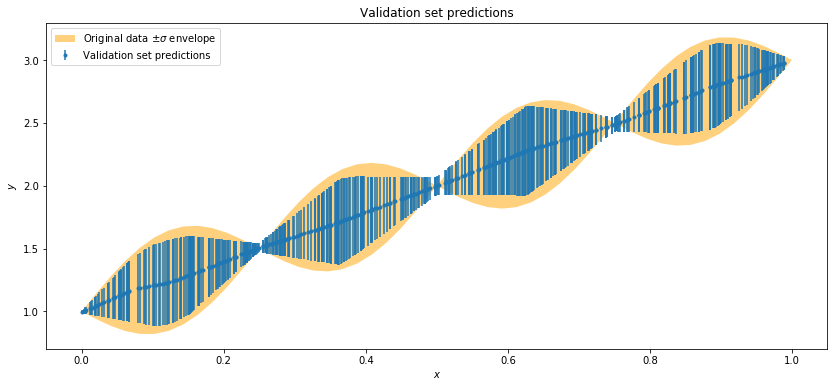

In [16]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_val, y_pred, yerr=sigma_pred, fmt='.');
#plt.errorbar(x_val, y_pred, fmt='.');
# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );

The following metric is to be compared with another notebook where variance is not trained in order to compare loss of precision.

In [60]:
m.r2_score(y_val[:,0],y_pred)

0.8009559643409793

For the record, the score training with variance is 0.8009559643409793 and training without variance is 0.8008319692729339.